In [1]:
import os
import random
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import warnings

warnings.filterwarnings(action='ignore')
torch.set_printoptions(sci_mode=True)

DATA_PATH = '/opt/ml/final-project-level3-recsys-05/Model/Model-Experiment/data'
MODEL_PATH = '/opt/ml/final-project-level3-recsys-05/Model/Model-Experiment/model'
VAL_TO_IDX_DATA_PATH = '/opt/ml/final-project-level3-recsys-05/Model/Model-Server/data'

In [18]:
from scipy.stats import beta

beta.rvs(max(100, 1), max(10, 1))

0.8391099075831651

In [2]:
import gc

gc.collect()
torch.cuda.empty_cache()

In [3]:
def seed_everything(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)  # if use multi-GPU
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    random.seed(seed)

In [4]:
import json

with open(os.path.join(VAL_TO_IDX_DATA_PATH, 'clean_problem_id_to_idx.json'), 'r', encoding = 'utf-8') as f:
    problemId_to_idx = json.load(f)

with open(os.path.join(VAL_TO_IDX_DATA_PATH, 'clean_idx_to_problem_id.json'), 'r', encoding = 'utf-8') as f:
    idx_to_problemId = json.load(f)

In [5]:
user_df = pd.read_csv(os.path.join(DATA_PATH, 'user.csv'))

In [6]:
def get_problems_to_idx(problems):
    problems = eval(problems)
    ret = []
    for problemId in problems:
        try: ret.append(int(problemId_to_idx[problemId]))
        except: continue
    return ret

user_df['problems_to_idx'] = user_df['problems'].apply(lambda x : get_problems_to_idx(x))

In [7]:
new_user_df = user_df[user_df['problems_to_idx'].apply(lambda x : True if len(x) >= 15 else False)].reset_index(drop = False)

In [8]:
user_name_to_idx = {}

for idx, user_name in enumerate(new_user_df['user_name'].tolist()):
    user_name_to_idx[user_name] = idx

In [9]:
num_user = len(user_name_to_idx)
num_item = len(problemId_to_idx)
total_items = [i for i in range(num_item)]

# 인접 행렬

In [10]:
import scipy.sparse as sp

def get_adj_matrix(new_user_df):
    R = sp.dok_matrix((num_user, num_item), dtype=np.float32)
    train_dict = {}
    valid_dict = {}

    group_df = new_user_df.groupby('user_name')

    for user_name, df in group_df:
        random.seed(22)
        total = df['problems_to_idx'].values[0]

        valid = random.sample(total, 10)
        train = list(set(total) - set(valid))

        R[user_name_to_idx[user_name], train] = 1.0

        train_dict[user_name_to_idx[user_name]] = train
        valid_dict[user_name_to_idx[user_name]] = valid

    def normalized_adj_mat(adj):
        rowsum = np.array(adj.sum(1))
        d_inv = np.power(rowsum, -.5).flatten()  
        d_inv[np.isinf(d_inv)] = 0.
        d_mat_inv = sp.diags(d_inv)
        norm_adj = d_mat_inv.dot(adj).dot(d_mat_inv)

        return norm_adj.tocoo()

    adj_mat = sp.dok_matrix((num_user + num_item, num_user + num_item), dtype=np.float32)
    adj_mat = adj_mat.tolil() # to_list
    R = R.tolil()

    adj_mat[:num_user, num_user:] = R
    adj_mat[num_user:, :num_user] = R.T
    adj_mat = adj_mat.todok() # to_dok_matrix

    adj_mat = normalized_adj_mat(adj_mat)
    return R, adj_mat, train_dict, valid_dict

# 모델

In [11]:
class LightGCN(nn.Module):
    def __init__(self, n_users, n_items, emb_dim, n_layers, reg, node_dropout, adj_mtx):
        super().__init__()

        # initialize Class attributes
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.u_final_embeddings = nn.Parameter(torch.rand((n_users, emb_dim)))
        self.i_final_embeddings = nn.Parameter(torch.rand((n_items, emb_dim)))

        self.n_users = n_users
        self.n_items = n_items
        self.emb_dim = emb_dim
        self.graph = self._convert_sp_mat_to_sp_tensor(adj_mtx)

        self.reg = reg
        self.n_layers = n_layers
        self.node_dropout = node_dropout

        # Initialize weights
        self.weight_dict = self._init_weights()
        print("Weights initialized.")

    # initialize weights
    def _init_weights(self):
        print("Initializing weights...")
        weight_dict = nn.ParameterDict()

        initializer = torch.nn.init.xavier_uniform_
        
        weight_dict['user_embedding'] = nn.Parameter(initializer(torch.empty(self.n_users, self.emb_dim).to(self.device)))
        weight_dict['item_embedding'] = nn.Parameter(initializer(torch.empty(self.n_items, self.emb_dim).to(self.device)))
        
        return weight_dict

    # convert sparse matrix into sparse PyTorch tensor
    def _convert_sp_mat_to_sp_tensor(self, X):
        """
        Convert scipy sparse matrix to PyTorch sparse matrix

        Arguments:
        ----------
        X = Adjacency matrix, scipy sparse matrix
        """
        coo = X.tocoo().astype(np.float32)
        i = torch.LongTensor(np.mat([coo.row, coo.col]))
        v = torch.FloatTensor(coo.data)
        res = torch.sparse.FloatTensor(i, v, coo.shape).to(self.device)
        return res

    # apply node_dropout
    def _droupout_sparse(self, X):
        """
        Drop individual locations in X
        
        Arguments:
        ---------
        X = adjacency matrix (PyTorch sparse tensor)
        dropout = fraction of nodes to drop
        noise_shape = number of non non-zero entries of X
        """
        node_dropout_mask = ((self.node_dropout) + torch.rand(X._nnz())).floor().bool().to(self.device)
        i = X.coalesce().indices()
        v = X.coalesce()._values()
        i[:,node_dropout_mask] = 0
        v[node_dropout_mask] = 0
        X_dropout = torch.sparse.FloatTensor(i, v, X.shape).to(self.device)

        return  X_dropout.mul(1/(1-self.node_dropout))

    def forward(self, u, i, j):
        """
        Computes the forward pass
        
        Arguments:
        ---------
        u = user
        i = positive item (user interacted with item)
        j = negative item (user did not interact with item)
        """
        # apply drop-out mask
        graph = self._droupout_sparse(self.graph) if self.node_dropout > 0 else self.graph
        ego_embeddings = torch.cat([self.weight_dict['user_embedding'], self.weight_dict['item_embedding']], 0)
        final_embeddings = [ego_embeddings]

        for k in range(self.n_layers):
            ego_embeddings = torch.sparse.mm(graph, final_embeddings[k])
            final_embeddings.append(ego_embeddings)                                       

        final_embeddings = torch.stack(final_embeddings, dim=1)
        final_embeddings = torch.mean(final_embeddings, dim=1)
        
        u_final_embeddings, i_final_embeddings = final_embeddings.split([self.n_users, self.n_items], 0)

        self.u_final_embeddings = nn.Parameter(u_final_embeddings)
        self.i_final_embeddings = nn.Parameter(i_final_embeddings)
        
        # loss 계산
        u_emb = u_final_embeddings[u] # user embeddings
        p_emb = i_final_embeddings[i] # positive item embeddings
        n_emb = i_final_embeddings[j] # negative item embeddings
        
        y_ui = torch.sum(torch.mul(u_emb, p_emb), dim = 1)                        
        y_uj = torch.sum(torch.mul(u_emb, n_emb), dim = 1)
        
        log_prob = torch.mean(torch.log(torch.sigmoid(y_ui - y_uj))) 
        bpr_loss = -log_prob        
        if self.reg > 0.:
            l2norm = (torch.sum(u_emb**2)/2. + torch.sum(p_emb**2)/2. + torch.sum(n_emb**2)/2.) / u_emb.shape[0]
            l2reg = self.reg * l2norm
            bpr_loss += l2reg

        return bpr_loss

# 학습 코드

In [12]:
class TrainCustomDataset(Dataset):
    def __init__(self, num_user, user_to_items):
        self.num_users = []
        self.pos_items = []
        self.neg_items = []

        for user in range(num_user):
            items = user_to_items[user]
            self.pos_items += items
            self.neg_items += np.random.choice(list(set(total_items) - set(items)), len(items)).tolist()
            self.num_users += [user] * len(items)

    def __len__(self):
        return len(self.num_users)

    def __getitem__(self, idx):
        return {
            'user' : self.num_users[idx],
            'pos_item' : self.pos_items[idx],
            'neg_item' : self.neg_items[idx],
            }

def train_make_collate_fn(samples):
    users = []
    pos_items = []
    neg_items = []
    for sample in samples:
        users += [sample['user']]
        pos_items += [sample['pos_item']]
        neg_items += [sample['neg_item']]
    return {
            'users' : users,
            'pos_items' : pos_items,
            'neg_items' : neg_items,
            }

class ValidCustomDataset(Dataset):
    def __init__(self, num_user):
        self.num_user = num_user

    def __len__(self):
        return self.num_user

    def __getitem__(self, idx):
        return {
            'user' : idx
            }

def valid_make_collate_fn(samples):
    users = [sample['user'] for sample in samples]
    return users

# def sampling(users, user_to_items):
#     pos_item = []
#     neg_item = []
#     for user in users:
#         items = user_to_items[user]
#         pos_item.extend(random.sample(items, 1))
#         neg_item.extend(random.sample(list(set(total_items) - set(items)), 1))
    
#     return pos_item, neg_item

def get_ndcg(pred_list, true_list):
    idcg = sum((1 / np.log2(rank + 2) for rank in range(len(true_list))))
    dcg = 0
    for rank, pred in enumerate(pred_list):
        if pred in true_list:
            dcg += 1 / np.log2(rank + 2)
    ndcg = dcg / idcg
    return ndcg

def get_hit(pred_list, true_list):
    hit_list = set(true_list) & set(pred_list)
    hit = len(hit_list) / len(true_list)
    return hit

def train(model, optimizer, data_loader):
    model.train()
    loss_val = 0

    for data in data_loader:
        optimizer.zero_grad()
        loss = model(data['users'], data['pos_items'], data['neg_items'])
        loss.backward()
        optimizer.step()
        loss_val += loss.item()

    loss_val /= len(data_loader)
    return loss_val

def evaluate(model, data_loader, R, user_to_items):
    model.eval()
    hit = 0
    ndcg = 0
    with torch.no_grad():
        score = torch.mm(model.u_final_embeddings, model.i_final_embeddings.T)
        score[R.todense() == 1] = -np.Inf
    
    for users in data_loader:
        users_rec = score[users]
        users_rec = users_rec.argsort()
        for user, user_rec in zip(users, users_rec):
            prediction = user_rec.cpu().numpy().tolist()[::-1][:10]
            target = user_to_items[user]

            hit += get_hit(prediction, target)
            ndcg += get_ndcg(prediction, target)
    
    return hit / len(data_loader.dataset), ndcg / len(data_loader.dataset)

# 학습

In [13]:
batch_size = 5000
num_workers = 8
epochs = 20
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_name = 'LightGCN'

emb_dim = 128
n_layers = 2
reg = 1e-5
node_dropout = 0.2
lr = 0.001

In [14]:
R, adj_mat, user_to_items_train_dict, user_to_items_valid_dict = get_adj_matrix(new_user_df)

In [15]:
seed_everything(22)

In [16]:
train_dataset = TrainCustomDataset(num_user = num_user, user_to_items = user_to_items_train_dict)
train_data_loader = DataLoader(
        train_dataset, 
        batch_size = batch_size, 
        shuffle = True, 
        drop_last = False,
        collate_fn = train_make_collate_fn,
        num_workers = num_workers)

valid_dataset = ValidCustomDataset(num_user = num_user)
valid_data_loader = DataLoader(
        valid_dataset, 
        batch_size = batch_size, 
        shuffle = False, 
        drop_last = False,
        collate_fn = valid_make_collate_fn,
        num_workers = num_workers)

In [15]:
model = LightGCN(
    n_users = num_user,
    n_items = num_item,
    emb_dim = emb_dim,
    n_layers = n_layers,
    reg = reg,
    node_dropout = node_dropout,
    adj_mtx = adj_mat,
    ).to(device)

model.load_state_dict(torch.load(os.path.join(MODEL_PATH, 'LightGCN.pt')))

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

Initializing weights...
Weights initialized.


In [18]:
best_ndcg = 0

for epoch in range(1, epochs + 1):
    tbar = tqdm(range(1))
    for _ in tbar:
            train_loss = train(model, optimizer, train_data_loader)
            hit, ndcg = evaluate(model, valid_data_loader, R, user_to_items = user_to_items_valid_dict)
            if best_ndcg < ndcg:
                best_epoch = epoch
                best_train_loss = train_loss
                best_ndcg = ndcg
                best_hit = hit
                torch.save(model.state_dict(), os.path.join(MODEL_PATH, model_name + '.pt'))

            tbar.set_description(f'Epoch: {epoch:3d}| Train loss: {train_loss:.5f}| NDCG@10: {ndcg:.5f}| HIT@10: {hit:.5f}')

print(f'BEST | Epoch: {best_epoch:3d}| Train loss: {best_train_loss:.5f}| NDCG@10: {best_ndcg:.5f}| HIT@10: {best_hit:.5f}')

Epoch:   1| Train loss: 0.16618| NDCG@10: 0.38170| HIT@10: 0.31584: 100%|██████████| 1/1 [50:26<00:00, 3026.94s/it]
Epoch:   2| Train loss: 0.13396| NDCG@10: 0.38734| HIT@10: 0.32172: 100%|██████████| 1/1 [50:29<00:00, 3029.88s/it]
Epoch:   3| Train loss: 0.11463| NDCG@10: 0.40225| HIT@10: 0.34039: 100%|██████████| 1/1 [50:32<00:00, 3032.50s/it]
Epoch:   4| Train loss: 0.10045| NDCG@10: 0.40423| HIT@10: 0.34280: 100%|██████████| 1/1 [50:16<00:00, 3016.79s/it]
Epoch:   5| Train loss: 0.09377| NDCG@10: 0.40925| HIT@10: 0.34811: 100%|██████████| 1/1 [50:22<00:00, 3022.88s/it]
Epoch:   6| Train loss: 0.08813| NDCG@10: 0.41108| HIT@10: 0.35073: 100%|██████████| 1/1 [50:31<00:00, 3031.05s/it]
Epoch:   7| Train loss: 0.08377| NDCG@10: 0.41267| HIT@10: 0.35365: 100%|██████████| 1/1 [50:25<00:00, 3025.30s/it]
Epoch:   8| Train loss: 0.08035| NDCG@10: 0.41357| HIT@10: 0.35481: 100%|██████████| 1/1 [50:20<00:00, 3020.48s/it]
  0%|          | 0/1 [17:29<?, ?it/s]


KeyboardInterrupt: 

In [16]:
model.load_state_dict(torch.load(os.path.join(MODEL_PATH, 'LightGCN-v1.pt')))

<All keys matched successfully>

In [17]:
vectors = model.i_final_embeddings.detach().cpu().numpy()

In [30]:
import pickle

EMBEDDING_PATH = '/opt/ml/final-project-level3-recsys-05/Model/Model-Experiment/embedding'

with open(os.path.join(EMBEDDING_PATH, 'LightGCN-Embedding.pickle'), 'wb') as file:
    pickle.dump(vectors, file, protocol = 4)

In [18]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, random_state = 0)
tsne_vectors = tsne.fit_transform(vectors)

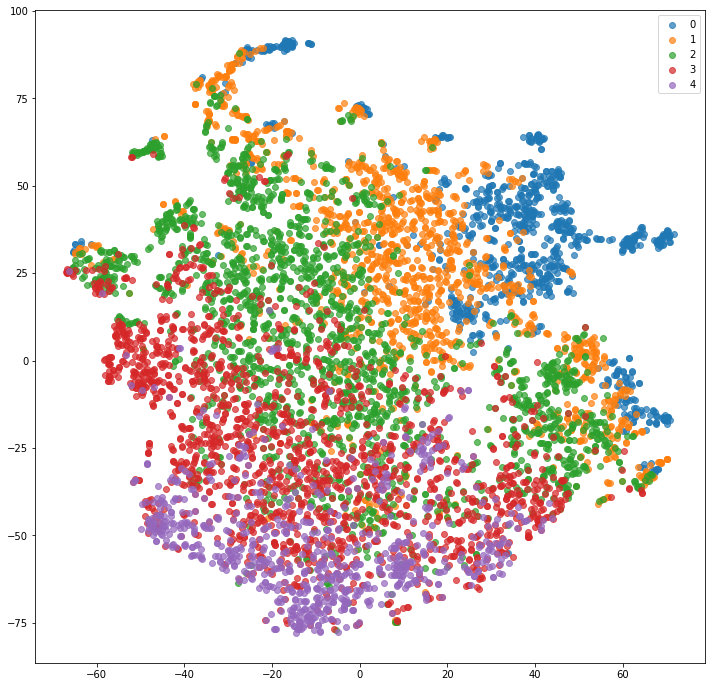

In [28]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12, 12))

problem_df = pd.read_csv(os.path.join(DATA_PATH, 'clean_problem.csv'))
problem_df['problem_id'] = problem_df['problem_id'].astype(str)
problem_df['problem_id2idx'] = problem_df['problem_id'].apply(lambda x : int(problemId_to_idx[x]))
problem_df['level_tag'] = problem_df['level'].apply(lambda x : (x - 1) // 5)

for level_tag in sorted(problem_df['level_tag'].unique()):
    idx = problem_df[problem_df['level_tag'] == level_tag]['problem_id2idx'].tolist()
    plt.scatter(x = tsne_vectors[idx, 0], y = tsne_vectors[idx, 1], alpha = 0.7, label = f'{level_tag}') 

plt.legend()
plt.show()

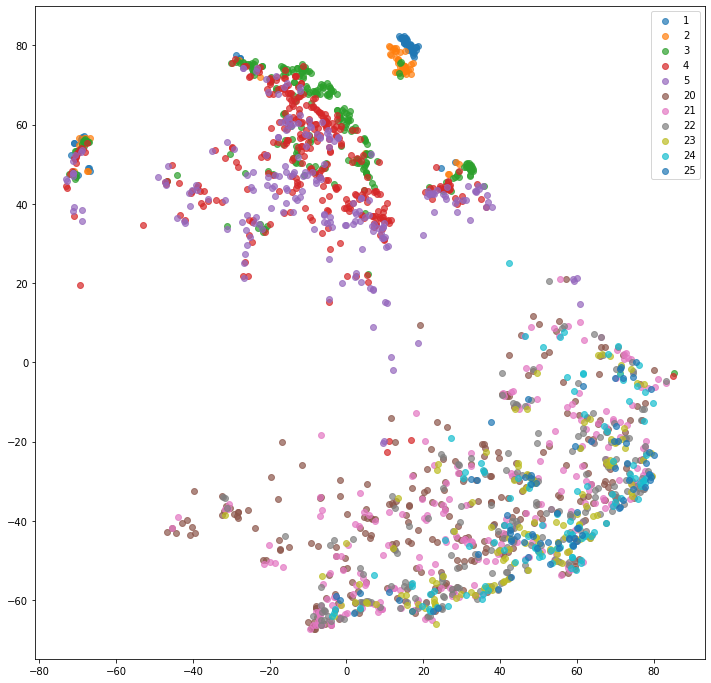

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12, 12))

problem_df = pd.read_csv(os.path.join(DATA_PATH, 'clean_problem.csv'))
problem_df['problem_id'] = problem_df['problem_id'].astype(str)
problem_df['problem_id2idx'] = problem_df['problem_id'].apply(lambda x : int(problemId_to_idx[x]))

for level in sorted(problem_df['level'].unique()):
    if level <= 5 or level >= 20:
        idx = problem_df[problem_df['level'] == level]['problem_id2idx'].tolist()
        plt.scatter(x = tsne_vectors[idx, 0], y = tsne_vectors[idx, 1], alpha = 0.7, label = f'{level}') 

plt.legend()
plt.show()

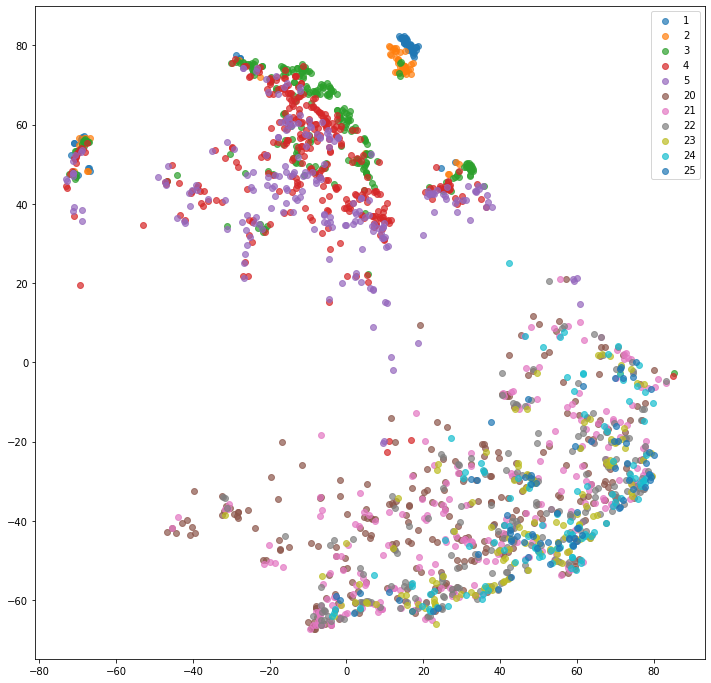

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize = (12, 12))

problem_df = pd.read_csv(os.path.join(DATA_PATH, 'clean_problem.csv'))
problem_df['problem_id'] = problem_df['problem_id'].astype(str)
problem_df['problem_id2idx'] = problem_df['problem_id'].apply(lambda x : int(problemId_to_idx[x]))

for level in sorted(problem_df['level'].unique()):
    if level <= 5 or level >= 20:
        idx = problem_df[problem_df['level'] == level]['problem_id2idx'].tolist()
        plt.scatter(x = tsne_vectors[idx, 0], y = tsne_vectors[idx, 1], alpha = 0.7, label = f'{level}') 

plt.legend()
plt.show()

In [ ]:
torch.load